## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## Set a Seed

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

## Load Dataset

In [ ]:
# Load the dataset from the UCI repository
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    df = pd.read_csv(url)
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nClass distribution:")
    print(df['status'].value_counts())  # Show class balance
    return df

## Scatter Plot

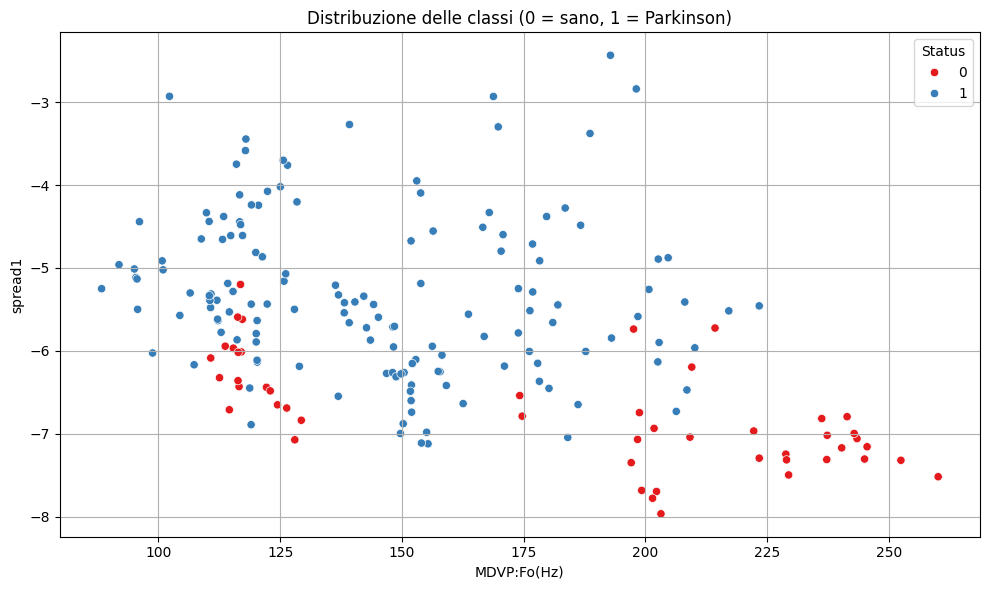

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data")

x_feature = 'MDVP:Fo(Hz)'
y_feature = 'spread1'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=x_feature, y=y_feature, hue='status', palette='Set1')
plt.title("Distribuzione delle classi (0 = sano, 1 = Parkinson)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title='Status')
plt.grid(True)
plt.tight_layout()
plt.show()

## Preprocess Data

In [ ]:
# Preprocess the data: separate features and target, then split
def preprocess_data(df):
    X = df.drop(['name', 'status'], axis=1)  # Remove non-numeric and target columns
    y = df['status']  # Target variable
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Pipeline with scaling and classifier

In [ ]:
# Build a machine learning pipeline with scaling and classifier
def build_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))  # Handle class imbalance
    ])
    return pipeline

## Find the best hyperparameters for classifiers

In [ ]:
# Perform grid search to find the best hyperparameters for the classifier
def tune_hyperparameters(pipeline, X_train, y_train):
    param_grid = {
        'classifier__n_estimators': [100, 200],       # Number of trees
        'classifier__max_depth': [None, 10, 20],      # Tree depth
        'classifier__min_samples_split': [2, 5]       # Minimum samples to split a node
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Cross-validation with stratified folds
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_  # Return the best model

## Evaluate Model

In [ ]:
# Evaluate the model on test data using various metrics and plots
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Classification performance report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Compute and print AUC-ROC score
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC: {auc:.4f}")
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    # Confusion matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

## Main Execution

Dataset loaded successfully!
Dataset shape: (195, 24)

Class distribution:
status
1    147
0     48
Name: count, dtype: int64
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39

AUC-ROC: 0.9621


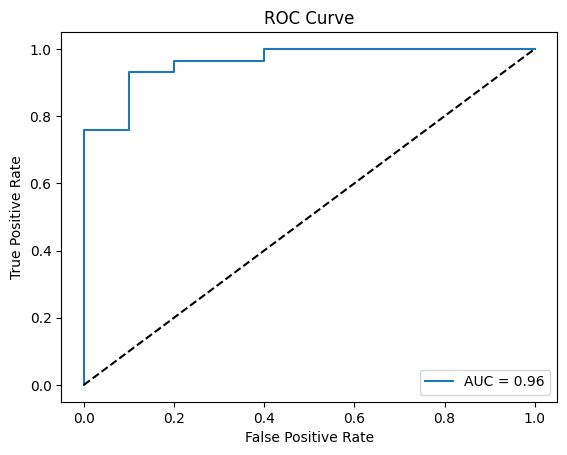

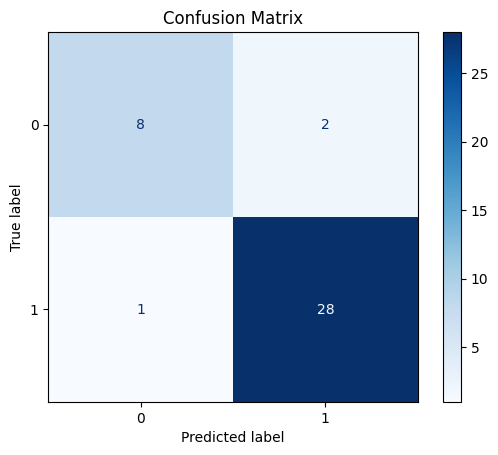

In [ ]:
# Main execution block
df = load_data()
X_train, X_test, y_train, y_test = preprocess_data(df)
pipeline = build_pipeline()
model = tune_hyperparameters(pipeline, X_train, y_train)
evaluate_model(model, X_test, y_test)

## Model Conversion from Scikit-Learn to TensorFlow Lite for Edge Deployment

In [ ]:
# ---------------------------------------
# CELL 1 - Required Imports
# ---------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import joblib

# ---------------------------------------
# CELL 2 - Train and Save scikit-learn Model
# ---------------------------------------
def train_sklearn_model():
    # Load Parkinson dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    df = pd.read_csv(url)

    # Prepare features and target
    X = df.drop(['name', 'status'], axis=1)
    y = df['status']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    # Save model components
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(model, 'rf_model.joblib')
    joblib.dump(list(X.columns), 'feature_names.joblib')

    return scaler, model, list(X.columns)

# ---------------------------------------
# CELL 3 - Define a TensorFlow Model
# ---------------------------------------
def create_tf_model(input_dim):
    # Simple feedforward neural network
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------------------
# CELL 4 - Transfer and Convert to TFLite
# ---------------------------------------
def transfer_to_tf_model(sklearn_model, scaler, feature_names):
    # Load the dataset again
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    df = pd.read_csv(url)
    X = df.drop(['name', 'status'], axis=1)
    y = df['status']

    # Scale using the same scaler
    X_scaled = scaler.transform(X)

    # Create and train a compatible TensorFlow model
    tf_model = create_tf_model(len(feature_names))
    tf_model.fit(X_scaled, y, epochs=10, verbose=0)  # Brief training

    # Save the Keras model
    tf_model.save('parkinsons_model.keras')

    # Convert to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
    tflite_model = converter.convert()

    # Save the .tflite model
    with open('parkinsons_model.tflite', 'wb') as f:
        f.write(tflite_model)

    return tf_model

# ---------------------------------------
# CELL 5 - Execute the Pipeline
# ---------------------------------------
print("Training scikit-learn model...")
scaler, sklearn_model, feature_names = train_sklearn_model()

print("Converting to TensorFlow Lite...")
tf_model = transfer_to_tf_model(sklearn_model, scaler, feature_names)

print("Model conversion completed successfully!")

# ---------------------------------------
# CELL 6 - Test the TFLite Model Inference
# ---------------------------------------
def test_tflite_model():
    # Load one sample input
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    df = pd.read_csv(url)
    X = df.drop(['name', 'status'], axis=1)[:1]  # First sample only
    X_scaled = scaler.transform(X)

    # Load the TensorFlow Lite model
    interpreter = tf.lite.Interpreter(model_path="parkinsons_model.tflite")
    interpreter.allocate_tensors()

    # Get tensor references
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set input and run inference
    input_data = X_scaled.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], [input_data[0]])
    interpreter.invoke()

    # Read output
    output_data = interpreter.get_tensor(output_details[0]['index'])

    print("\nTFLite Inference completed.")
    print("Output shape:", output_data.shape)
    print("Prediction probabilities:", output_data[0])

# Run test
test_tflite_model()

Training scikit-learn model...
Converting to TensorFlow Lite...
Saved artifact at '/tmp/tmp0y1e3toh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 22), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134201066684240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134203016281744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134203016276368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134203016278480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134203016271952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134203016276176: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model conversion completed successfully!

TFLite Inference completed.
Output shape: (1, 2)
Prediction probabilities: [0.01445067 0.9855494 ]
